In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error
import warnings
import itertools
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
import scipy.stats.kde as kde
from scipy.stats import norm

# Read 16S data

In [21]:
df_16S = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,0.0,108301.701888,7101.750943,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,63028.039623,0.0,0.0,0.0,165115.709436,0.0,0.0,0.0,1.322701e+05
sample132,0.0,405068.034693,50064.588558,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,80103.341692,0.0,0.0,0.0,106501.033841,0.0,0.0,0.0,1.003112e+06
sample133,0.0,36169.603950,45332.570284,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,221840.237562,0.0,0.0,0.0,1.866352e+05
sample134,0.0,484302.054587,10150.043060,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,105850.449056,0.0,0.0,0.0,919303.900024,0.0,0.0,0.0,8.714537e+05
sample135,0.0,91489.970533,42374.302141,0.0,0.0,0.0,0.0,0.0,12519.680178,0.0,...,0.0,0.000000,0.0,0.0,0.0,581683.602124,0.0,0.0,0.0,5.335310e+05


# Add pseudocount for zeros

In [22]:
for sample_id in df_16S.index:
    sample = np.array(df_16S.loc[sample_id])
    minval = np.min(sample[np.nonzero(sample)]) # minimum non-zero value
    sample[sample==0] = minval
    df_16S.loc[sample_id] = sample
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,887.718868,108301.701888,7101.750943,887.718868,887.718868,887.718868,887.718868,887.718868,887.718868,887.718868,...,887.718868,63028.039623,887.718868,887.718868,887.718868,165115.709436,887.718868,887.718868,887.718868,1.322701e+05
sample132,910.265247,405068.034693,50064.588558,910.265247,910.265247,910.265247,910.265247,910.265247,910.265247,910.265247,...,910.265247,80103.341692,910.265247,910.265247,910.265247,106501.033841,910.265247,910.265247,910.265247,1.003112e+06
sample133,482.261386,36169.603950,45332.570284,482.261386,482.261386,482.261386,482.261386,482.261386,482.261386,482.261386,...,482.261386,482.261386,482.261386,482.261386,482.261386,221840.237562,482.261386,482.261386,482.261386,1.866352e+05
sample134,2900.012303,484302.054587,10150.043060,2900.012303,2900.012303,2900.012303,2900.012303,2900.012303,2900.012303,2900.012303,...,2900.012303,105850.449056,2900.012303,2900.012303,2900.012303,919303.900024,2900.012303,2900.012303,2900.012303,8.714537e+05
sample135,1926.104643,91489.970533,42374.302141,1926.104643,1926.104643,1926.104643,1926.104643,1926.104643,12519.680178,1926.104643,...,1926.104643,1926.104643,1926.104643,1926.104643,1926.104643,581683.602124,1926.104643,1926.104643,1926.104643,5.335310e+05


# Read metadata for inulin and control

In [23]:
df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[(df_meta.Diet=='Inulin') | (df_meta.Diet=='Control')]
df_meta['Diet'] = [1 if g=='Inulin' else 0 for g in df_meta['Diet']]
df_meta.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup
SampleID,,,,,
sample131,BC1,Beijing,0,0,C
sample132,BC2,Beijing,0,0,B
sample133,BC3,Beijing,0,0,A
sample134,BC4,Beijing,0,0,D
sample135,BC5,Beijing,0,0,E


# Select the 20 most abundant taxa

In [24]:
topX = 20
df_16S_T = df_16S.loc[df_meta.index].T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Muribaculaceae,Bacteroides_dash_acidifaciens,Akkermansia_dash_muciniphila,Faecalibaculum,Parasutterella,Bacteroides,Alloprevotella,Bacteroides_dash_uniformis,Lachnospiraceae,Parabacteroides_dash_goldsteinii,Lachnospiraceae_dash_NK4A136_dash_group,Desulfovibrionaceae,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Oscillospiraceae,Helicobacter_dash_ganmani,Escherichia_dash_Shigella,Rikenellaceae_dash_RC9_dash_gut_dash_group,Mucispirillum_dash_schaedleri,Clostridia_dash_vadinBB60_dash_group
SampleID,,,,,,,,,,,,,,,,,,,,
sample131,2.178906e+07,1.682227e+06,3.771030e+06,2.175266e+07,2.213083e+06,3.826068e+05,9.717858e+06,69242.071699,3.380433e+06,103863.107548,2.719971e+06,1.819824e+05,170442.022643,1.012000e+05,6.249541e+05,5326.313208,32845.598114,6.779509e+06,2.008020e+06,470491.000005
sample132,2.539822e+07,4.455748e+06,2.610641e+06,1.732963e+07,3.591907e+06,2.645231e+06,2.849130e+05,100129.177115,4.563160e+06,59167.241023,3.721164e+06,9.912789e+05,71910.954474,7.898372e+06,3.932346e+06,11833.448205,18205.304930,3.418046e+06,1.345281e+07,142911.643701
sample133,1.379895e+07,1.339240e+06,3.729327e+06,1.250166e+07,4.753168e+06,7.802989e+05,1.040238e+06,49672.922758,7.508810e+05,46297.093056,7.354486e+05,1.504656e+05,55460.059390,2.083369e+05,5.290407e+05,5304.875246,9645.227720,5.057957e+06,4.054854e+06,175060.883119
sample134,3.867746e+07,1.024574e+07,2.262880e+07,2.484296e+07,4.982221e+06,4.157168e+06,3.694616e+06,126150.535177,8.172235e+06,184150.781235,4.120917e+06,2.321460e+06,69600.295270,1.566007e+05,5.088072e+06,20300.086120,40600.172241,2.312180e+07,5.086622e+06,194300.824295
sample135,1.994192e+07,4.775776e+06,4.727624e+06,1.935254e+07,3.164590e+06,1.040097e+06,1.814391e+06,25039.360356,1.251005e+06,72228.924105,1.094990e+06,2.725438e+05,533530.986054,6.067230e+04,5.441246e+05,6741.366250,33706.831249,1.064558e+07,7.617744e+05,45263.459106


In [25]:
list(df_16S_topX.columns)

['Muribaculaceae',
 'Bacteroides_dash_acidifaciens',
 'Akkermansia_dash_muciniphila',
 'Faecalibaculum',
 'Parasutterella',
 'Bacteroides',
 'Alloprevotella',
 'Bacteroides_dash_uniformis',
 'Lachnospiraceae',
 'Parabacteroides_dash_goldsteinii',
 'Lachnospiraceae_dash_NK4A136_dash_group',
 'Desulfovibrionaceae',
 'Clostridia_dash_UCG_dash_014',
 'Lachnospiraceae_dash_bacterium_dash_28_dash_4',
 'Oscillospiraceae',
 'Helicobacter_dash_ganmani',
 'Escherichia_dash_Shigella',
 'Rikenellaceae_dash_RC9_dash_gut_dash_group',
 'Mucispirillum_dash_schaedleri',
 'Clostridia_dash_vadinBB60_dash_group']

# Normalize max value of 16S data to 1

In [26]:
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX_w_meta = pd.merge(df_meta, df_16S_topX/df_16S_topX.max().max(), left_index=True, right_index=True, how='inner')
df_16S_topX_w_meta.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Muribaculaceae,Bacteroides_dash_acidifaciens,Akkermansia_dash_muciniphila,Faecalibaculum,Parasutterella,...,Lachnospiraceae_dash_NK4A136_dash_group,Desulfovibrionaceae,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Oscillospiraceae,Helicobacter_dash_ganmani,Escherichia_dash_Shigella,Rikenellaceae_dash_RC9_dash_gut_dash_group,Mucispirillum_dash_schaedleri,Clostridia_dash_vadinBB60_dash_group
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,BC1,Beijing,0,0,C,0.058612,0.004525,0.010144,0.058514,0.005953,...,0.007317,0.000490,0.000458,0.000272,0.001681,0.000014,0.000088,0.018237,0.005401,0.001266
sample132,BC2,Beijing,0,0,B,0.068320,0.011986,0.007023,0.046616,0.009662,...,0.010010,0.002666,0.000193,0.021246,0.010578,0.000032,0.000049,0.009194,0.036187,0.000384
sample133,BC3,Beijing,0,0,A,0.037119,0.003602,0.010032,0.033629,0.012786,...,0.001978,0.000405,0.000149,0.000560,0.001423,0.000014,0.000026,0.013606,0.010907,0.000471
sample134,BC4,Beijing,0,0,D,0.104041,0.027561,0.060870,0.066826,0.013402,...,0.011085,0.006245,0.000187,0.000421,0.013687,0.000055,0.000109,0.062197,0.013683,0.000523
sample135,BC5,Beijing,0,0,E,0.053643,0.012847,0.012717,0.052057,0.008513,...,0.002945,0.000733,0.001435,0.000163,0.001464,0.000018,0.000091,0.028636,0.002049,0.000122


# Calculate log-derivatives (dlog(B)/dt)

In [27]:
df_deriv = deepcopy(df_16S_topX_w_meta)
for curr_mice in set(df_deriv.MiceID):
    curr_df = df_deriv[df_deriv.MiceID==curr_mice]
    for taxon in bacterial_taxa:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv.loc[df_deriv.MiceID==curr_mice, taxon] = ydata_d1
df_deriv.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Muribaculaceae,Bacteroides_dash_acidifaciens,Akkermansia_dash_muciniphila,Faecalibaculum,Parasutterella,...,Lachnospiraceae_dash_NK4A136_dash_group,Desulfovibrionaceae,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Oscillospiraceae,Helicobacter_dash_ganmani,Escherichia_dash_Shigella,Rikenellaceae_dash_RC9_dash_gut_dash_group,Mucispirillum_dash_schaedleri,Clostridia_dash_vadinBB60_dash_group
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,BC1,Beijing,0,0,C,-0.035769,-0.001958,-0.015449,-0.122249,-0.014135,...,-2.365448e-03,0.080151,0.002214,-0.006143,0.008517,0.003323,0.001625,0.009386,-0.003710,-0.000439
sample132,BC2,Beijing,0,0,B,-0.065024,-0.017470,-0.011927,-0.093016,-0.018327,...,8.422057e-03,0.127021,0.000410,-0.030942,-0.003068,0.045131,0.000424,0.005349,-0.044840,0.000987
sample133,BC3,Beijing,0,0,A,-0.003791,-0.010972,-0.010358,-0.071602,-0.031663,...,7.933539e-07,0.036681,0.004060,-0.000361,0.008703,0.009558,0.003965,0.004809,-0.016021,0.010510
sample134,BC4,Beijing,0,0,D,-0.010212,-0.037511,-0.094830,-0.071193,-0.010250,...,2.616074e-02,0.003099,0.001159,0.000587,0.013388,0.000030,-0.000006,-0.020317,-0.012572,0.004581
sample135,BC5,Beijing,0,0,E,0.071871,-0.004578,-0.016798,-0.029205,-0.000383,...,2.071616e-02,0.008314,-0.001196,0.002778,0.004650,0.000011,-0.000011,-0.012629,0.003524,0.002131


# Construct regression matrix

In [16]:
# Ymat should be samples by bacteria
Ymat = df_deriv[bacterial_taxa].values
Ymat = Ymat.flatten(order='F')
Ymat = StandardScaler().fit_transform(Ymat.reshape(-1,1)).reshape(1,-1)[0] # standardize
Ymat

array([-0.83447306, -1.47426183, -0.13514241, ..., -0.05649319,
       -0.0596165 , -0.05797334])

In [17]:
len(Ymat)

6740

In [18]:
Xmat = np.zeros(shape=(topX*len(df_deriv.index), (topX+2)*topX))
for k in np.arange(topX):
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topX+2)] = 1
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topX+2)+1] = df_deriv.Diet.values
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topX+2)+2:(k+1)*(topX+2)] = df_16S_topX_w_meta[bacterial_taxa].values
Xmat

array([[1.00000000e+00, 0.00000000e+00, 5.86115481e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 6.83200226e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 3.71185148e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05807481e-04, 2.58294734e-04, 1.02695497e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.15959266e-04, 2.21611042e-04, 6.69986871e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.33952716e-05, 1.84699513e-05, 7.38798051e-06]])

# Write stan program

## write data

In [32]:
json_str = '{\n"N" : %d,\n'%(len(Ymat))

# y variable
json_str += '\"dlogX\" : [%s],\n'%(','.join(list(Ymat.astype(str))))

# x variable
for k1,c1 in enumerate(bacterial_taxa):
    # growth rate
    json_str += '\"growth_rate_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topX+2)].astype(str))))
    # diet response
    json_str += '\"inulin_response_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topX+2)+1].astype(str))))
    # bacterial interactions
    for k2,c2 in enumerate(bacterial_taxa):
        v = list(Xmat[:,k1*(topX+2)+2+k2].astype(str))
        json_str += '\"pairwise_interaction_%s_%s\" : [%s]'%(c1,c2,','.join(v))
        if c1 == bacterial_taxa[-1] and c2 == bacterial_taxa[-1]:
            json_str += '\n}'
        else:
            json_str += ',\n'
#print(json_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa/mice_scfa.data.json", "w")
text_file.write("%s" % json_str)
text_file.close()

## write model

In [33]:
# data block
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dlogX;\n'
for c1 in bacterial_taxa:
    model_str += '\tvector[N] growth_rate_%s;\n'%(c1)
    model_str += '\tvector[N] inulin_response_%s;\n'%(c1)
    for c2 in bacterial_taxa:
        model_str += '\tvector[N] pairwise_interaction_%s_%s;\n'%(c1,c2)
model_str += '}\n'

# parameter block
model_str += 'parameters {\n\treal<lower=0,upper=1> sigma;\n'
for c1 in bacterial_taxa:
    model_str += '\treal alpha__%s;\n'%(c1) # growth rate
    model_str += '\treal epsilon__%s;\n'%(c1) # inulin response
    for c2 in bacterial_taxa:
        model_str += '\treal beta__%s_%s;\n'%(c1,c2)
model_str += '}\n'       
        
# model block
model_str += 'model {\n\tsigma ~ uniform(0,1);\n'
for c1 in bacterial_taxa:
    model_str += '\talpha__%s ~ normal(0,1);\n'%(c1) # growth rate
    model_str += '\tepsilon__%s ~ normal(0,1);\n'%(c1) # inulin response
    for c2 in bacterial_taxa:
        model_str += '\tbeta__%s_%s ~ normal(0,1);\n'%(c1,c2)
model_str += '\tdlogX ~ normal('
for c1 in bacterial_taxa:
    model_str += 'alpha__%s*growth_rate_%s+'%(c1,c1) # growth rate
    model_str += 'epsilon__%s*inulin_response_%s+'%(c1,c1) # inulin response
    for c2 in bacterial_taxa:
        if c1 == bacterial_taxa[-1] and c2 == bacterial_taxa[-1]:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s'%(c1,c2,c1,c2)
        else:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s+'%(c1,c2,c1,c2)
model_str += ', sigma);\n}'
#print(model_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa/mice_scfa.stan", "w")
text_file.write("%s" % model_str)
text_file.close()

# Plot stan output

In [22]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [23]:
fit = az.from_cmdstan(["output_%d.csv"%(i) for i in np.arange(1,4)])

In [27]:
lines = []
    
# basal growth rate
for c in bacterial_taxa:
    var = 'alpha__%s'%(c)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['basal_growth_rate', c, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
# inulin response
for c in bacterial_taxa:
    var = 'epsilon__%s'%(c)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['inulin_response', c, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])

# pairwise interactions
for c1 in bacterial_taxa:
    for c2 in bacterial_taxa:
        var = 'beta__%s_%s'%(c1,c2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        assert len(hpd_mu) == 1
        (x0, x1) = hpd_mu[0]
        lines.append(['pairwise_interaction', (c1,c2), var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
df_stan_output_summary = pd.DataFrame(lines, columns = ['Type','Taxa','Variable','Left','Right','Middle','Median','SNR','Significant'])
df_stan_output_summary.head()

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
0,basal_growth_rate,Muribaculaceae,alpha__Muribaculaceae,-0.16,0.15,-0.005,-0.003450,-0.044859,False
1,basal_growth_rate,Bacteroides_dash_acidifaciens,alpha__Bacteroides_dash_acidifaciens,-0.01,0.30,0.145,0.145751,1.835619,False
2,basal_growth_rate,Akkermansia_dash_muciniphila,alpha__Akkermansia_dash_muciniphila,-0.27,0.04,-0.115,-0.112445,-1.416896,False
3,basal_growth_rate,Faecalibaculum,alpha__Faecalibaculum,-0.20,0.12,-0.040,-0.041872,-0.531562,False
4,basal_growth_rate,Parasutterella,alpha__Parasutterella,-0.20,0.12,-0.040,-0.043561,-0.540205,False


In [28]:
df_stan_output_summary.to_excel('bayesian_regression_summary_top20.xlsx')

# Plot posterior of significant coefficients

In [ ]:
df_stan_output_summary = pd.read_excel('bayesian_regression_summary_top20.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True].reset_index(drop=True)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Type=='inulin_response']

fig, ax = plt.subplots(figsize=(3,10), nrows=len(df_stan_output_summary.index), ncols=1, sharex=True)

for idx in df_stan_output_summary.index:
    _type = df_stan_output_summary.loc[idx,'Type']
    _taxa = df_stan_output_summary.loc[idx,'Taxa']
    _left = df_stan_output_summary.loc[idx,'Left']
    _middle = df_stan_output_summary.loc[idx,'Middle']
    _right = df_stan_output_summary.loc[idx,'Right']
    if _type == 'inulin_response':
        var = 'epsilon__%s'%(_taxa)
    if _type == 'pairwise_interaction':
        var = 'beta__%s_%s'%(eval(_taxa)[0],eval(_taxa)[1])
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    mean,std=norm.fit(data)
    x = np.linspace(-1, 3, 100)
    y = norm.pdf(x, mean, std)
    ax[idx].plot(x,y)
    ax[idx].plot([_left,_left],[0,np.max(y)], 'k--')
    ax[idx].plot([_right,_right],[0,np.max(y)], 'k--')
    ax[idx].set_ylabel(_taxa)
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bayesian_inference_gLV.svg", format="svg")

# Compare data and simulation

In [13]:
def gLV(t, y, bacterial_taxa, params):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            dc1_dt += params[pairwise_interaction_var]*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('bayesian_regression_summary_top20.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_16S_topX_w_meta = df_16S_topX_w_meta[df_16S_topX_w_meta.Diet==1] # just inulin

# solve the model
all_mice = set(df_16S_topX_w_meta.MiceID)
xcorr = np.linspace(0,31,311)
df_obs_pred = None
for curr_mice in all_mice:
    curr_df = df_16S_topX_w_meta[df_16S_topX_w_meta.MiceID==curr_mice]
    init_conc = list(curr_df.loc[curr_df.Day==0,bacterial_taxa].values)[0]
    # sol.t, sol.y (# number of taxa x numberr of time point)
    sol = solve_ivp(gLV, [0,31], init_conc, args=(bacterial_taxa,params), method='BDF', t_eval=xcorr)
    # print(np.max(sol.t), curr_mice, np.min(sol.y), np.max(sol.y))
    
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol.t)-xcorr[-1])<1e-6:
        # get a copy of curr_df but replace observed values with simulated values
        curr_df_pred = deepcopy(curr_df)
        for k,t in enumerate(bacterial_taxa):
            cs = CubicSpline(sol.t, sol.y[k])
            curr_df_pred[t] = cs(curr_df_pred.Day)

        # add column to indicate observation or prediction
        curr_df['ValueType'] = 'Observation'
        curr_df_pred['ValueType'] = 'Prediction'
    
        if df_obs_pred is None:
            df_obs_pred = pd.concat([curr_df, curr_df_pred], ignore_index=True)
        else:
            df_obs_pred = pd.concat([df_obs_pred, curr_df, curr_df_pred], ignore_index=True)

df_obs_pred.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Muribaculaceae,Bacteroides_dash_acidifaciens,Akkermansia_dash_muciniphila,Faecalibaculum,Parasutterella,...,Desulfovibrionaceae,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Oscillospiraceae,Helicobacter_dash_ganmani,Escherichia_dash_Shigella,Rikenellaceae_dash_RC9_dash_gut_dash_group,Mucispirillum_dash_schaedleri,Clostridia_dash_vadinBB60_dash_group,ValueType
0,BI5,Beijing,0,1,C,0.120006,0.009655,0.001689,0.028938,0.000213,...,0.020388,0.005059,0.000258,0.004760,0.009660,0.000240,0.012667,0.001694,0.002998,Observation
1,BI5,Beijing,1,1,C,0.105643,0.401196,0.000815,0.130929,0.024998,...,0.000677,0.000288,0.006894,0.002494,0.000042,0.000156,0.000468,0.046872,0.000018,Observation
2,BI5,Beijing,3,1,C,0.381225,0.061769,0.055441,0.206595,0.039453,...,0.001468,0.000260,0.000509,0.000807,0.000005,0.000005,0.000282,0.004584,0.000103,Observation
3,BI5,Beijing,5,1,C,0.449913,0.003618,0.047487,0.191312,0.057690,...,0.000628,0.004144,0.000667,0.000871,0.000039,0.000220,0.000275,0.002465,0.000024,Observation
4,BI5,Beijing,8,1,C,0.381101,0.002430,0.002601,0.040795,0.063532,...,0.000326,0.022523,0.000668,0.000386,0.000047,0.000107,0.000129,0.001093,0.000043,Observation


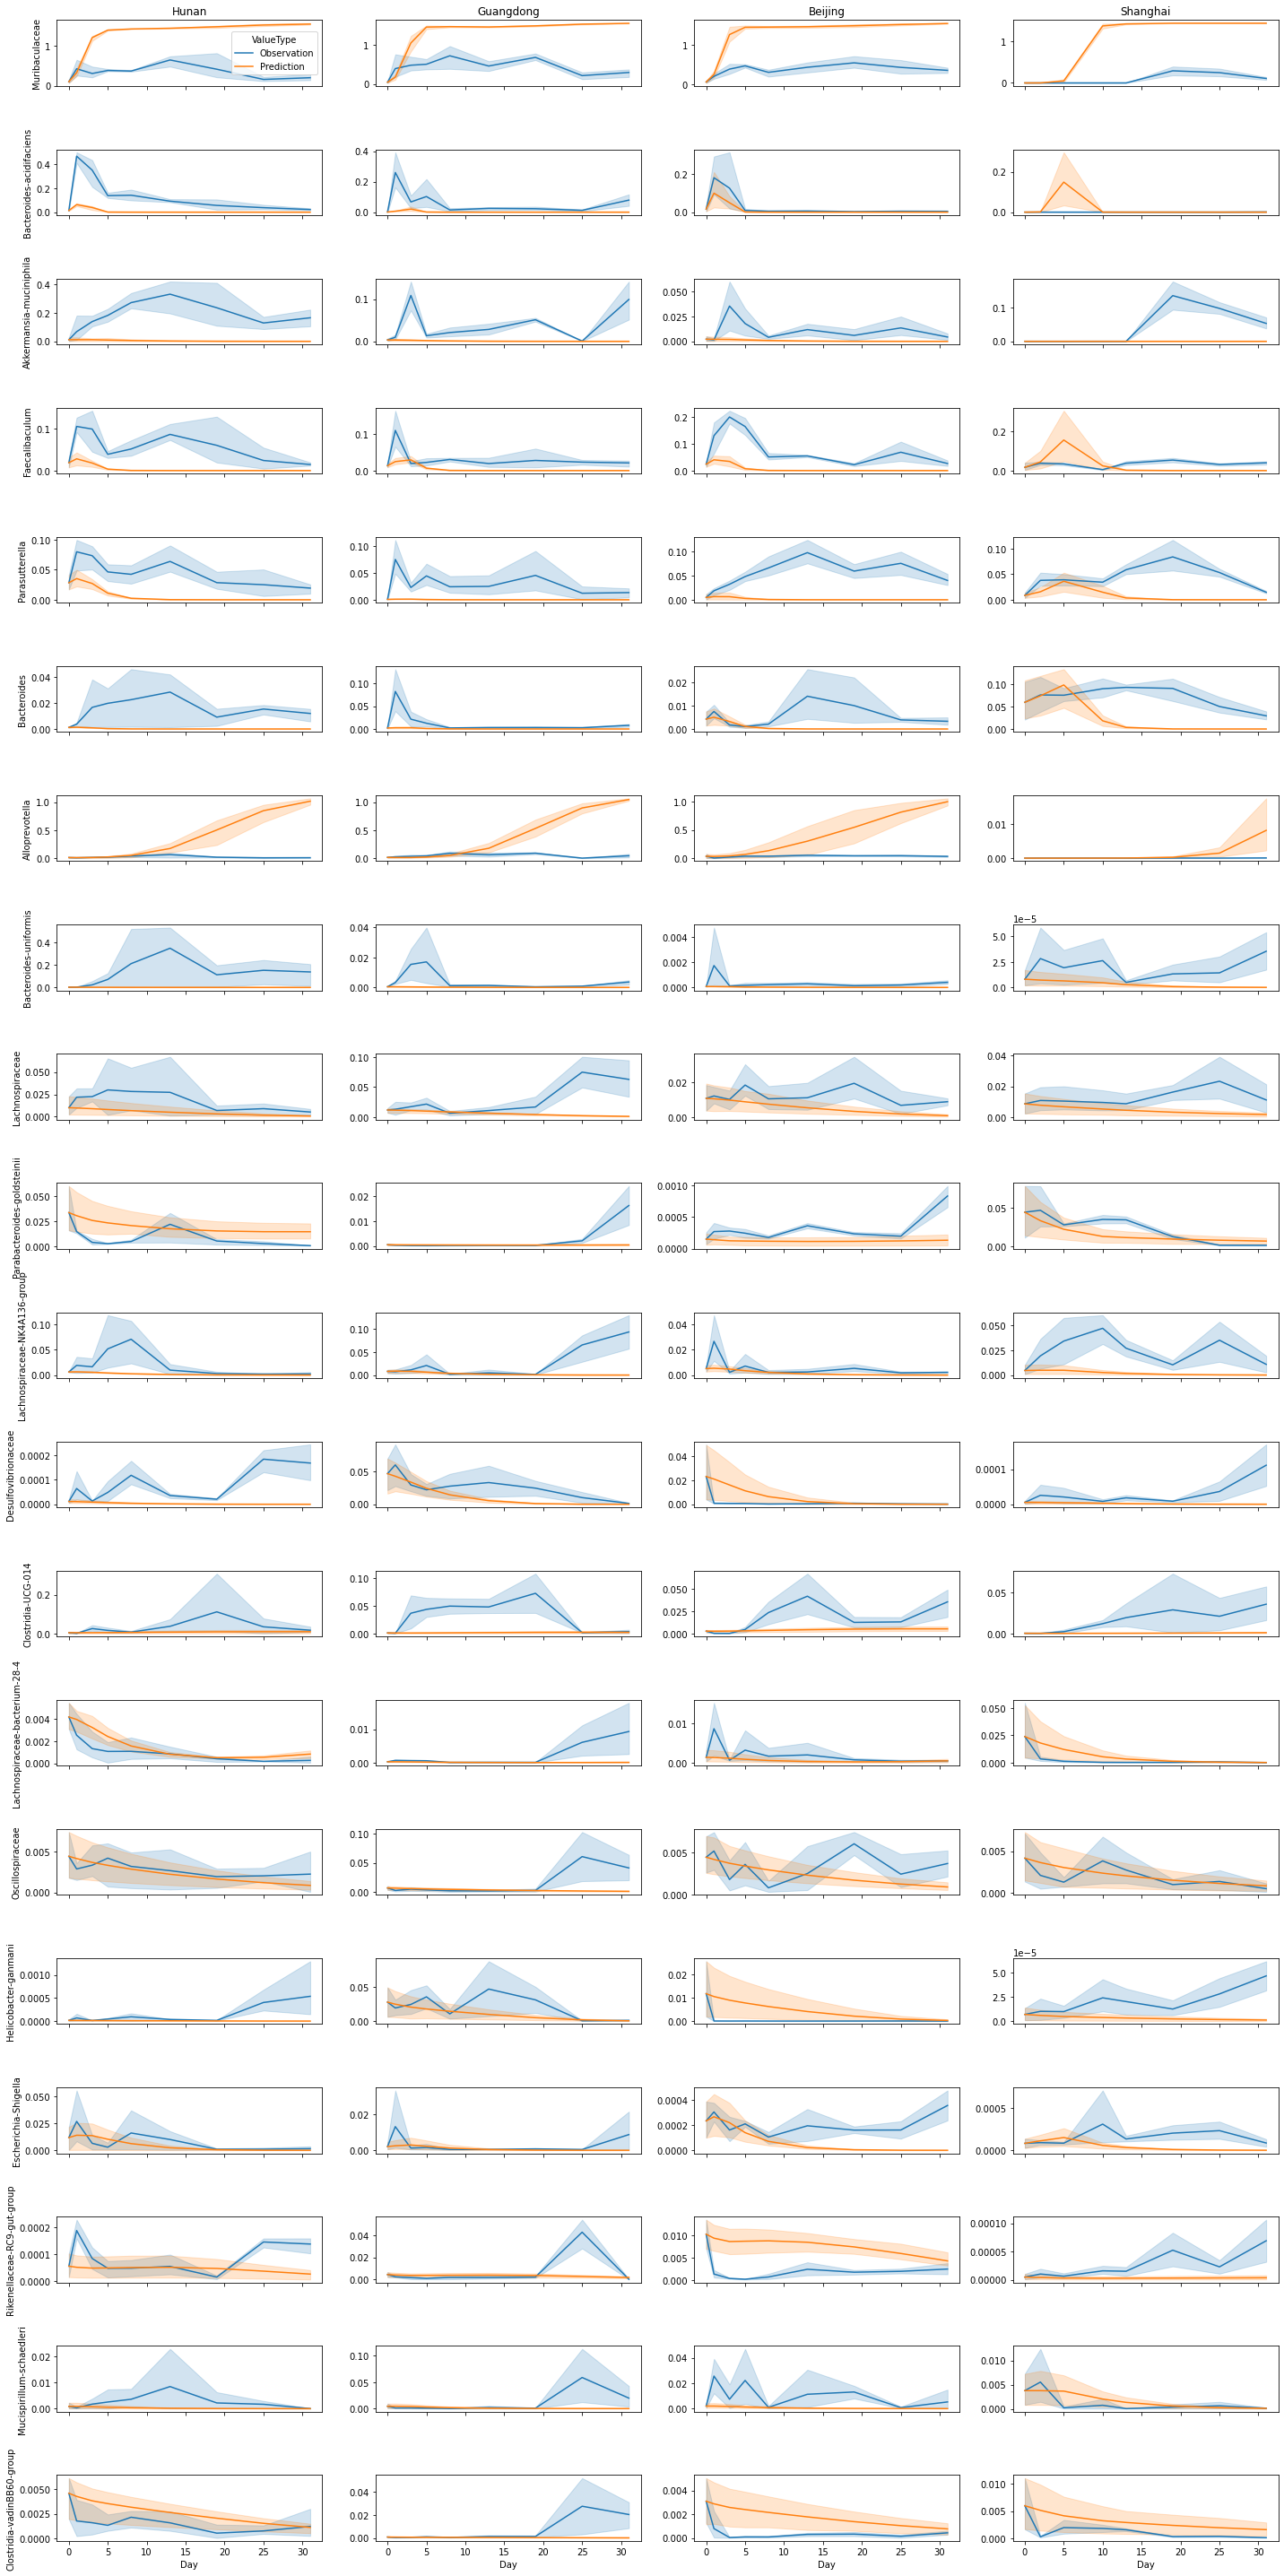

In [14]:
fig, ax = plt.subplots(nrows=20, ncols=4, figsize=(20,40), sharex=True)

for j,vendor in enumerate(set(df_obs_pred.Vendor)):
    for i,t in enumerate(bacterial_taxa):
        _ = sns.lineplot(x='Day', y=t, hue='ValueType', data=df_obs_pred[df_obs_pred.Vendor==vendor], ax=ax[i,j])
        if i!=0 or j!=0:
            ax[i,j].legend().remove()
        ax[i,j].set_ylabel(t)
        if i==0:
            ax[i,j].set_title(vendor)
        
        if j==0:
            ax[i,j].set_ylabel(t.replace('_slash_','/').replace('_space_',' ').replace('_leftsquarebracket_','[').replace('_rightsquarebracket_',']').replace('_dash_','-').replace('_dot_','.').replace('_leftroundbracket','(').replace('_rightroundbracket_',')'))
        else:
            ax[i,j].set_ylabel('')
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("gLV_training.png", format="png")

# Simulate effect of removing B. acidaficiens and Muribaculaceae

In [41]:
def gLV(t, y, bacterial_taxa, params):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            dc1_dt += params[pairwise_interaction_var]*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('bayesian_regression_summary_top20.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_16S_topX_w_meta = df_16S_topX_w_meta[df_16S_topX_w_meta.Diet==1] # just inulin

# solve the model
all_mice = set(df_16S_topX_w_meta.MiceID)
xcorr = np.linspace(0,5,100)
lines = []
for curr_mice in all_mice:
    curr_df = df_16S_topX_w_meta[df_16S_topX_w_meta.MiceID==curr_mice]
    vendor = list(set(curr_df['Vendor']))[0]
    
    # intact baseline
    init_conc1 = list(curr_df.loc[curr_df.Day==0,bacterial_taxa].values)[0]
    sol1 = solve_ivp(gLV, [0,31], init_conc1, args=(bacterial_taxa,params), method='BDF', t_eval=xcorr)
    
    # perturbed baseline
    init_conc2 = list(curr_df.loc[curr_df.Day==0,bacterial_taxa].values)[0]
    init_conc2[bacterial_taxa.index('Muribaculaceae')] = 0
    init_conc2[bacterial_taxa.index('Bacteroides_dash_acidifaciens')] = 0
    sol2 = solve_ivp(gLV, [0,31], init_conc2, args=(bacterial_taxa,params), method='BDF', t_eval=xcorr)
    
    print(curr_mice, vendor, sol1.t[-1], sol2.t[-1])
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol1.t)-xcorr[-1])<1e-6 and np.abs(np.max(sol2.t)-xcorr[-1])<1e-6:
        sol1_total = sol1.t*0
        sol2_total = sol2.t*0
        for k,taxa in enumerate(bacterial_taxa):
            sol1_total += sol1.y[k]
            sol2_total += sol2.y[k]
        density_ratio = sol2_total/sol1_total
        for k,v in zip(sol1.t, density_ratio):
            lines.append([curr_mice, vendor, k, v])
        
df_remove_top2 = pd.DataFrame(lines, columns=['MiceID','Vendor','Time','FC'])
df_remove_top2.head()

BI5 Beijing 5.0 5.0
HI5 Hunan 5.0 5.0
BI3 Beijing 5.0 5.0
HI2 Hunan 5.0 5.0
BI2 Beijing 5.0 5.0
HI4 Hunan 5.0 3.7878787878787876
SI4 Shanghai 5.0 5.0
SI5 Shanghai 5.0 5.0
BI4 Beijing 5.0 5.0
GI1 Guangdong 5.0 5.0
SI2 Shanghai 5.0 5.0
GI3 Guangdong 5.0 5.0
SI1 Shanghai 5.0 5.0
SI3 Shanghai 5.0 5.0
HI1 Hunan 5.0 5.0
GI2 Guangdong 5.0 5.0
BI1 Beijing 5.0 5.0
GI4 Guangdong 5.0 5.0


,MiceID,Vendor,Time,FC
0,BI5,Beijing,0.000000,0.567932
1,BI5,Beijing,0.050505,0.552147
2,BI5,Beijing,0.101010,0.536357
3,BI5,Beijing,0.151515,0.520796
4,BI5,Beijing,0.202020,0.505464


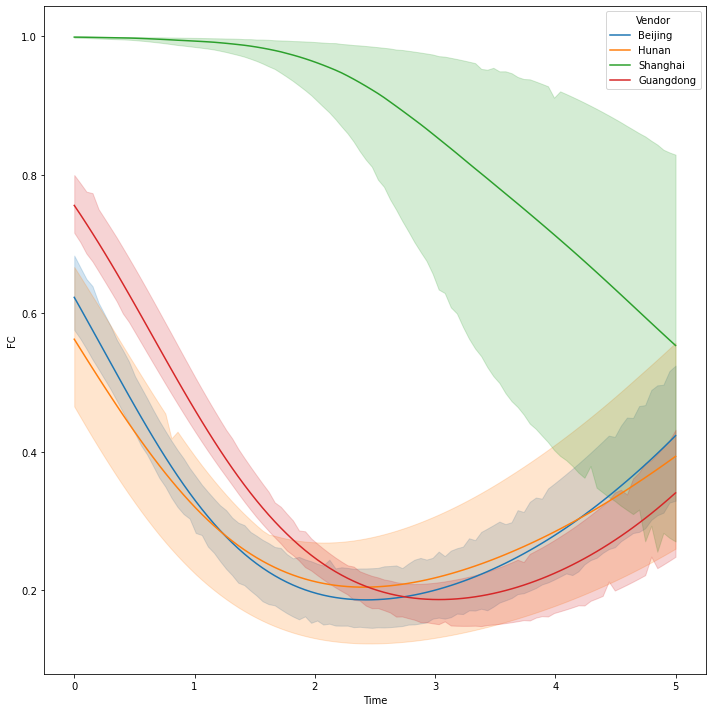

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
_ = sns.lineplot(x='Time', y='FC', hue='Vendor', data=df_remove_top2, ax=ax)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("density_ratio_remove_top2.png", format="png")

# Simulate the effects of removing outgoing links of B. acidaficiens and Muribaculaceae

In [39]:
def gLV(t, y, bacterial_taxa, params, flag):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            coef = params[pairwise_interaction_var]
            if flag and (c2=='Muribaculaceae' or c2=='Bacteroides_dash_acidifaciens') and coef>0:
                pass
            else:
                dc1_dt += coef*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('bayesian_regression_summary_top20.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_16S_topX_w_meta = df_16S_topX_w_meta[df_16S_topX_w_meta.Diet==1] # just inulin

# solve the model
all_mice = set(df_16S_topX_w_meta.MiceID)
xcorr = np.linspace(0,5,100)
lines = []
for curr_mice in all_mice:
    curr_df = df_16S_topX_w_meta[df_16S_topX_w_meta.MiceID==curr_mice]
    vendor = list(set(curr_df['Vendor']))[0]
    init_conc = list(curr_df.loc[curr_df.Day==0,bacterial_taxa].values)[0]

    # intact interaction network
    sol1 = solve_ivp(gLV, [0,31], init_conc, args=(bacterial_taxa,params,0), method='BDF', t_eval=xcorr)
    
    # perturbed interaction network
    sol2 = solve_ivp(gLV, [0,31], init_conc, args=(bacterial_taxa,params,1), method='BDF', t_eval=xcorr)
    
    # print(curr_mice, vendor, sol1.t[-1], sol2.t[-1])
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol1.t)-xcorr[-1])<1e-6 and np.abs(np.max(sol2.t)-xcorr[-1])<1e-6:
        sol1_total = sol1.t*0
        sol2_total = sol2.t*0
        for k,taxa in enumerate(bacterial_taxa):
            sol1_total += sol1.y[k]
            sol2_total += sol2.y[k]
        density_ratio = sol2_total/sol1_total
        for k,v in zip(sol1.t, density_ratio):
            lines.append([curr_mice, vendor, k, v])
        
df_remove_top2 = pd.DataFrame(lines, columns=['MiceID','Vendor','Time','FC'])
df_remove_top2.head()

,MiceID,Vendor,Time,FC
0,BI5,Beijing,0.000000,1.000000
1,BI5,Beijing,0.050505,0.999286
2,BI5,Beijing,0.101010,0.998529
3,BI5,Beijing,0.151515,0.997733
4,BI5,Beijing,0.202020,0.996897


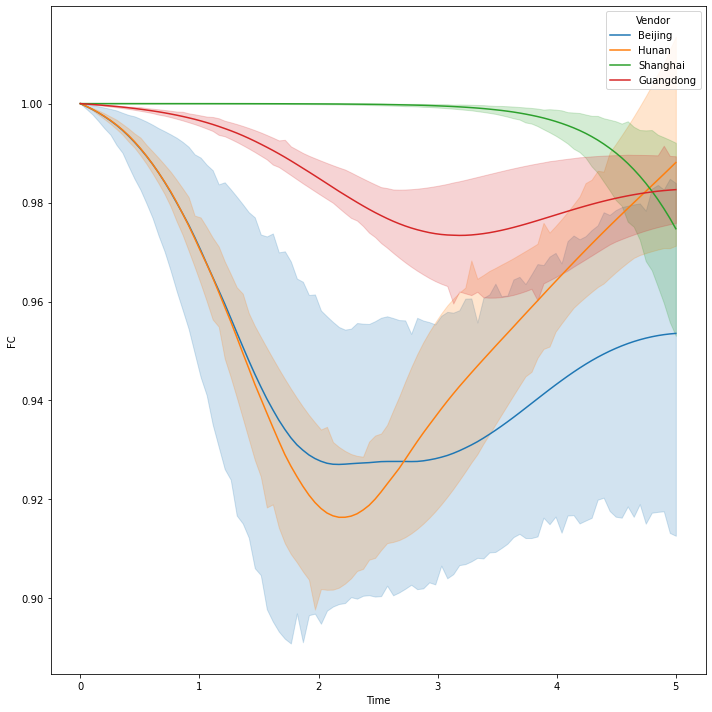

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
_ = sns.lineplot(x='Time', y='FC', hue='Vendor', data=df_remove_top2, ax=ax)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("density_ratio_remove_top2_outgoing_links.png", format="png")